Raw data shape: (7504, 7)
  Gender Ethinic     Age_Category  Year  Population  AgeStart Age Bucket
0   Male  Malays    15 - 19 Years  2023       17324        15      15–64
1   Male  Malays    15 - 19 Years  2022       17629        15      15–64
2   Male  Malays    15 - 19 Years  2021       18200        15      15–64
3   Male  Malays    15 - 19 Years  2020       19135        15      15–64
4   Male  Malays    15 - 19 Years  2019       19957        15      15–64

After cleaning:
Gender          object
Ethinic         object
Age_Category    object
Year             int64
Population       int64
AgeStart         int64
Age Bucket      object
dtype: object

Aggregated by Year & Age Bucket (head):
        0–14   15–64    65+
Year                       
1957  619104  795764  31061
1958  664500  820600  33700
1959  705500  846000  35700
1960  747600  861300  37500
1961  780000  883600  38800
Bucket columns found: ['0–14', '15–64', '65+']
Normalized bucket columns: ['0-14', '15-64', '65+']

Yearly 

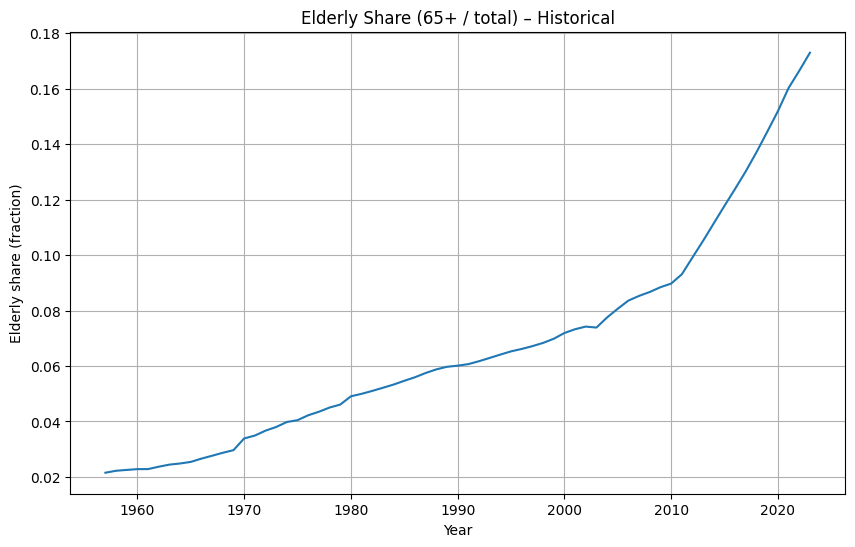


=== Stationarity Tests on Elderly Share ===
ADF statistic: 2.9805, p-value: 1.0000
ADF critical values: {'1%': np.float64(-3.5352168748293127), '5%': np.float64(-2.9071540828402367), '10%': np.float64(-2.5911025443786984)}
KPSS statistic: 0.2305, p-value: 0.0100
KPSS critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


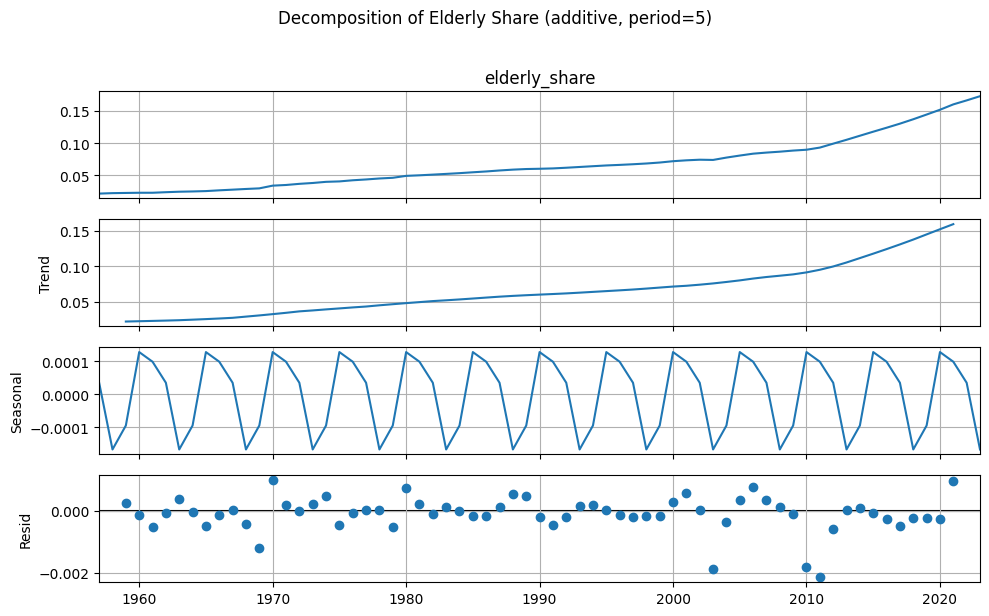

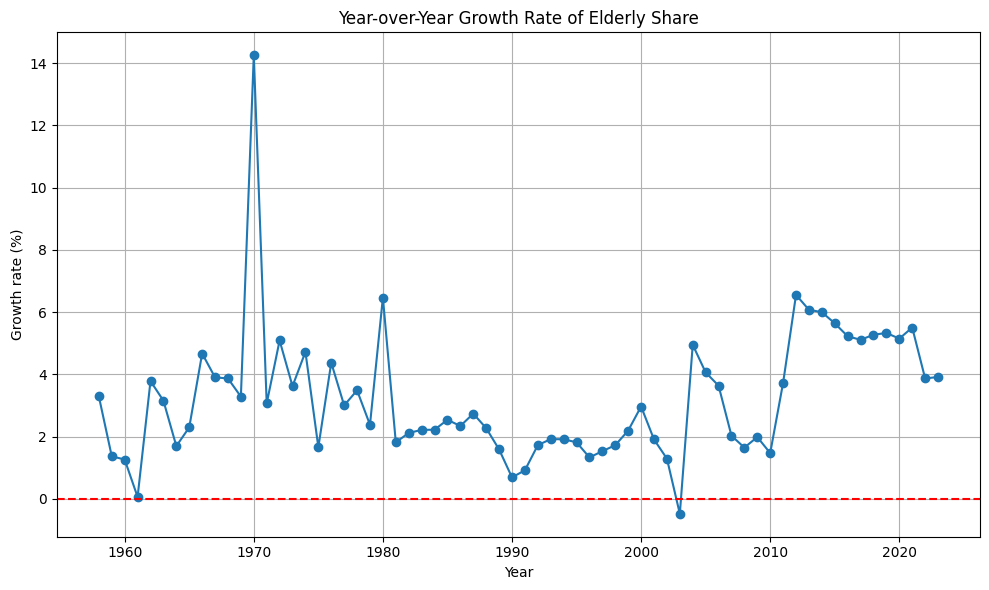


Growth rate summary (percent):
count    66.000000
mean      3.232446
std       2.135882
min      -0.478249
25%       1.817775
50%       2.854926
75%       4.298240
max      14.255066
Name: elderly_share, dtype: float64

=== TS Cross-validation – ETS (Holt-Winters) ===
ETS Fold 1: train 1957–1968, test 1969–1979
ETS Fold 2: train 1957–1979, test 1980–1990
ETS Fold 3: train 1957–1990, test 1991–2001
ETS Fold 4: train 1957–2001, test 2002–2012
ETS Fold 5: train 1957–2012, test 2013–2023
ETS metrics: {'RMSE': np.float64(0.010832181185743498), 'MAE': 0.0058478570798868685, 'MAPE(%)': np.float64(6.09785283152489), 'R2': 0.9090789609369827}

=== TS Cross-validation – ARIMA(1,1,1) ===
ARIMA Fold 1: train 1957–1968, test 1969–1979
ARIMA Fold 2: train 1957–1979, test 1980–1990
ARIMA Fold 3: train 1957–1990, test 1991–2001
ARIMA Fold 4: train 1957–2001, test 2002–2012
ARIMA Fold 5: train 1957–2012, test 2013–2023
ARIMA metrics: {'RMSE': np.float64(0.018646213815759118), 'MAE': 0.0115323436310523

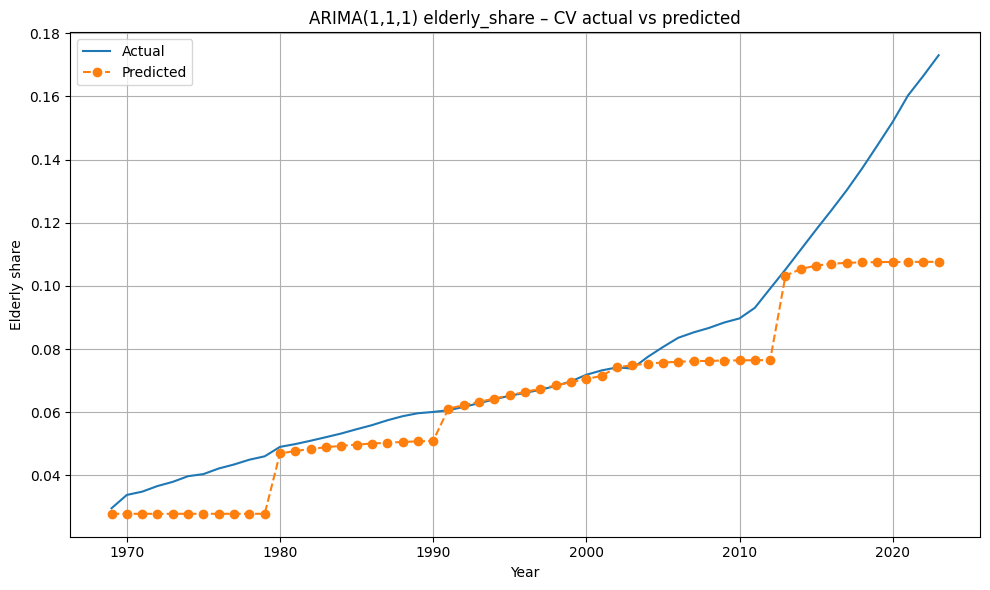

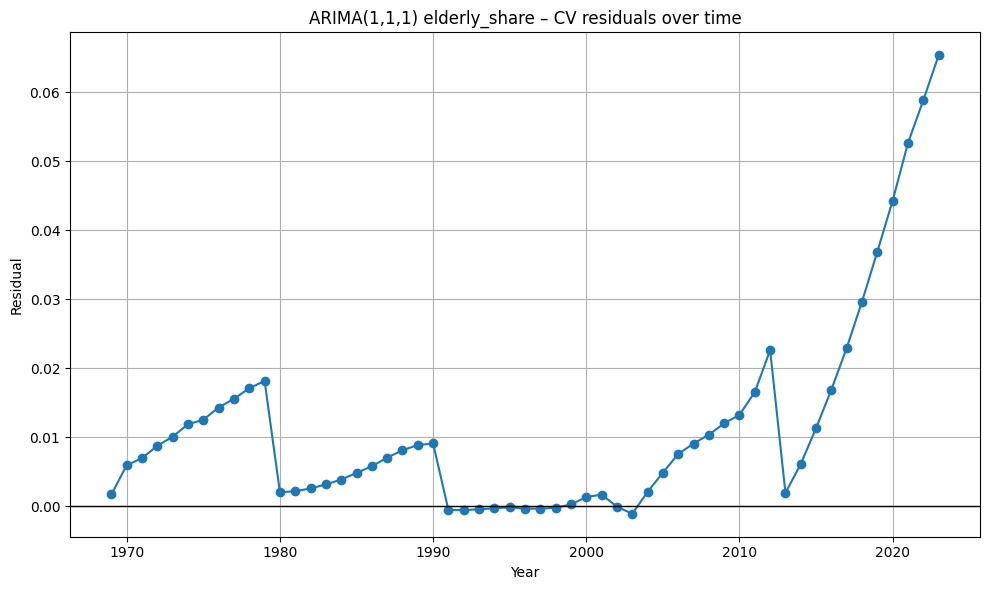

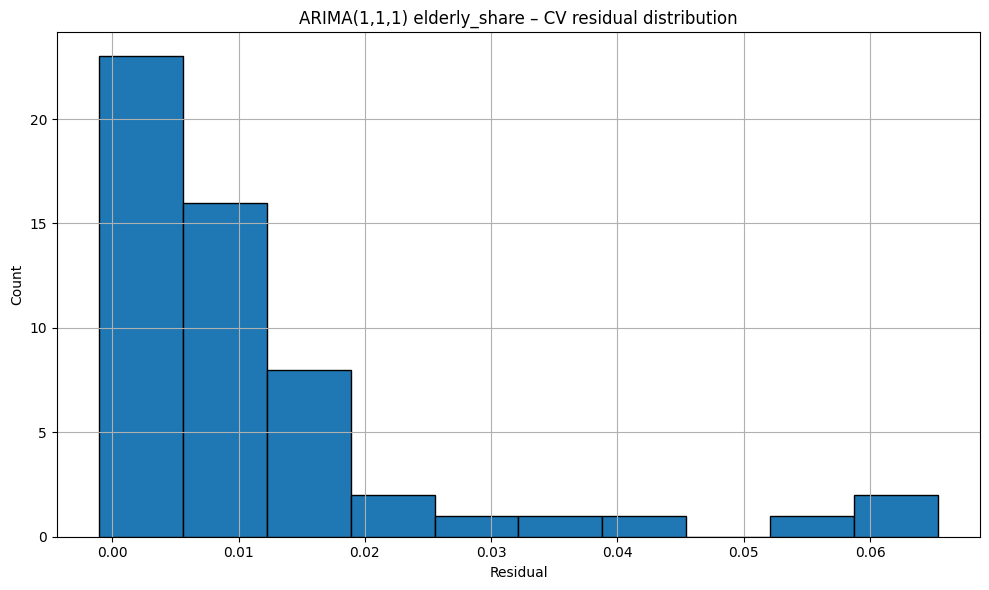

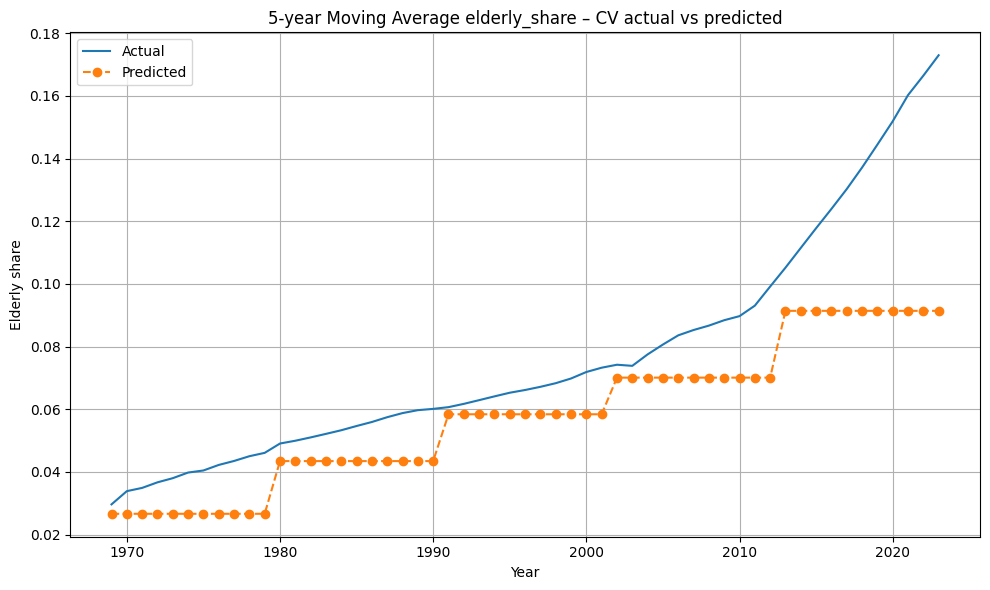

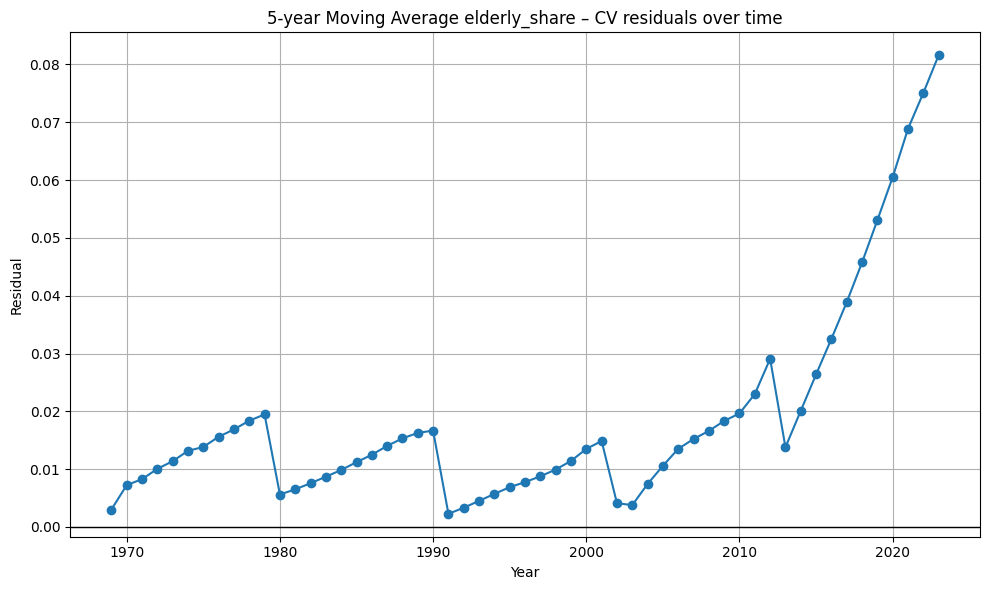

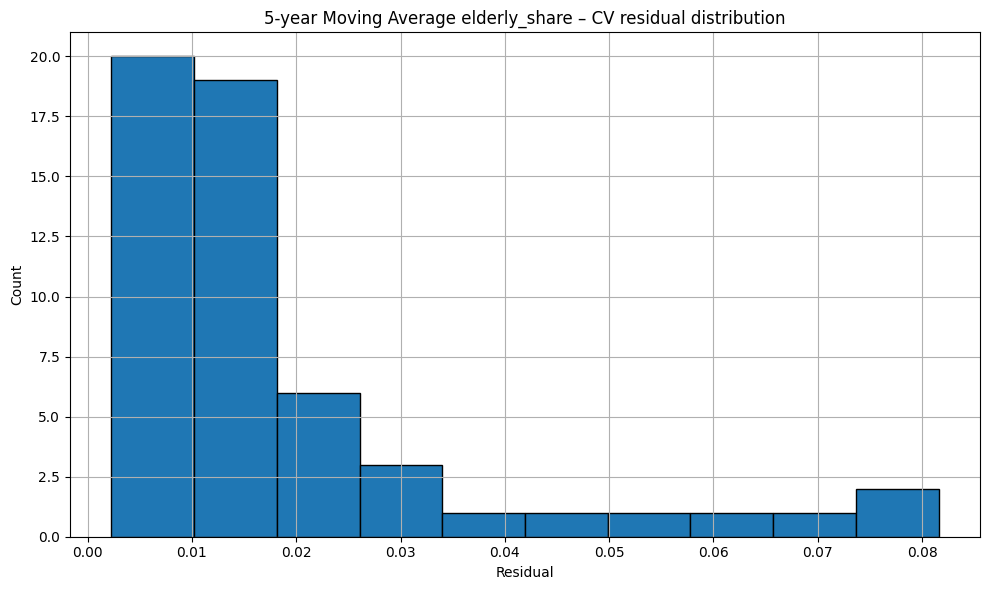


Final ARIMA summary:
                               SARIMAX Results                                
Dep. Variable:          elderly_share   No. Observations:                   67
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 336.268
Date:                Sun, 07 Dec 2025   AIC                           -666.535
Time:                        04:11:10   BIC                           -659.966
Sample:                             0   HQIC                          -663.940
                                 - 67                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5878      0.082      7.179      0.000       0.427       0.748
ma.L1          0.4432      0.117      3.795      0.000       0.214       0.672
sigma2      2.172e-06   3.68e-

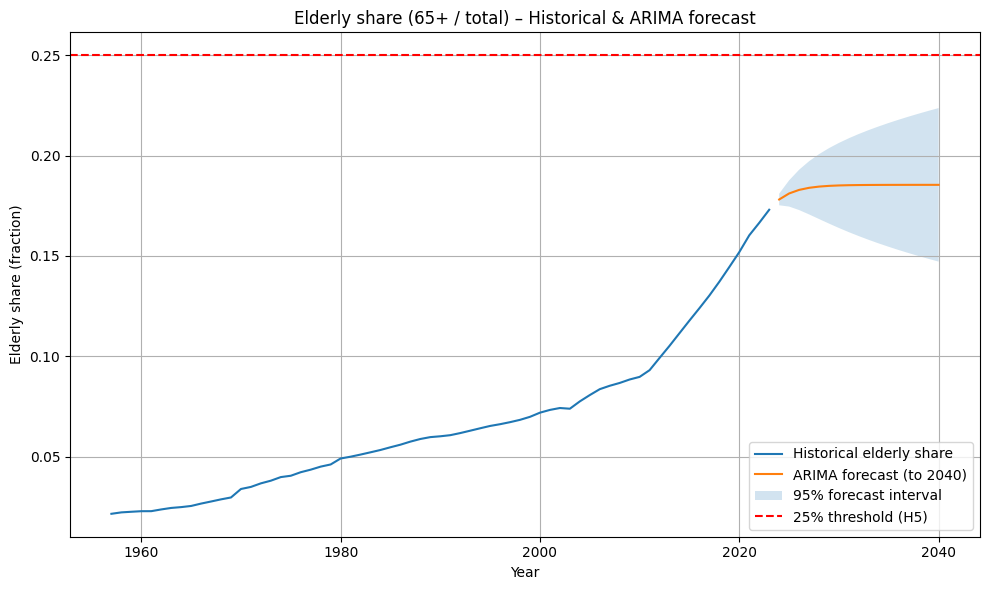

In [ ]:
# ============================================================
# Predictive Analysis – Singapore Ageing (65+ share)
# Using cleaned "All Ethnic & Gender for Time series Analysis" CSV from Drive
#
# NEW:
#   - Moving Average baseline model (5-year window) with TS cross-validation
#   - Stationarity tests: ADF and KPSS
#   - Time-series decomposition (trend / resid)
#   - Year-over-year growth rate analysis
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

# ------------------------------------------------------------
# 1. Load data from Google Drive
# ------------------------------------------------------------

url = "https://drive.google.com/uc?id=1YDrdq_eAGEfTPLh1U2O7pzfqOtGIzlcC"

df = pd.read_csv(url, header=0)
print("Raw data shape:", df.shape)
print(df.head())

df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
df["Population"] = pd.to_numeric(df["Population"], errors="coerce")

df = df.dropna(subset=["Year", "Population"])
df["Year"] = df["Year"].astype(int)

print("\nAfter cleaning:")
print(df.dtypes)

# ------------------------------------------------------------
# 2. Aggregate to yearly totals using Age Bucket
# ------------------------------------------------------------

bucket_year = (
    df.groupby(["Year", "Age Bucket"])["Population"]
      .sum()
      .unstack("Age Bucket")
)
bucket_year.columns.name = None
print("\nAggregated by Year & Age Bucket (head):")
print(bucket_year.head())
print("Bucket columns found:", list(bucket_year.columns))

# Normalize different dash characters (0–14 -> 0-14 etc.)
bucket_year = bucket_year.rename(
    columns=lambda c: str(c).replace("–", "-").replace("—", "-")
)
print("Normalized bucket columns:", list(bucket_year.columns))

rename_map = {
    "0-14": "child_0_14",
    "15-64": "working_15_64",
    "65+": "elderly_65plus"
}
bucket_year = bucket_year.rename(columns=rename_map)

expected_cols = ["child_0_14", "working_15_64", "elderly_65plus"]
missing = [c for c in expected_cols if c not in bucket_year.columns]
if missing:
    raise ValueError(f"Missing bucket columns after rename: {missing}")

yearly = bucket_year.copy()
yearly["total_pop"] = (
    yearly["child_0_14"]
    + yearly["working_15_64"]
    + yearly["elderly_65plus"]
)

yearly["elderly_share"] = yearly["elderly_65plus"] / yearly["total_pop"]
yearly["AI"] = yearly["elderly_65plus"] / yearly["child_0_14"]
yearly["OADR"] = yearly["elderly_65plus"] / yearly["working_15_64"]

yearly = yearly.sort_index()
print("\nYearly time series (head):")
print(yearly.head())

# Quick sanity plot
yearly["elderly_share"].plot(title="Elderly Share (65+ / total) – Historical")
plt.ylabel("Elderly share (fraction)")
plt.show()

elderly_share = yearly["elderly_share"]

# ------------------------------------------------------------
# 3. Stationarity tests (ADF & KPSS) on elderly_share
# ------------------------------------------------------------

print("\n=== Stationarity Tests on Elderly Share ===")

# ADF: H0 = non-stationary (unit root)
adf_result = adfuller(elderly_share)
print(f"ADF statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
print("ADF critical values:", adf_result[4])

# KPSS: H0 = trend-stationary
# For annual series, use regression='ct' (constant + trend)
kpss_result = kpss(elderly_share, regression='ct', nlags="auto")
print(f"KPSS statistic: {kpss_result[0]:.4f}, p-value: {kpss_result[1]:.4f}")
print("KPSS critical values:", kpss_result[3])

# ------------------------------------------------------------
# 4. Time-series decomposition (additive, pseudo-5-year period)
#    (mainly to visualise trend & residual; annual data has no true seasonality)
# ------------------------------------------------------------

decomp = seasonal_decompose(elderly_share, model="additive", period=5)
decomp.plot()
plt.suptitle("Decomposition of Elderly Share (additive, period=5)", y=1.02)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 5. Year-over-year growth rate analysis
# ------------------------------------------------------------

growth_rate = elderly_share.pct_change() * 100.0
plt.plot(growth_rate.index, growth_rate.values, marker="o")
plt.axhline(0, linestyle="--", color="red")
plt.title("Year-over-Year Growth Rate of Elderly Share")
plt.xlabel("Year")
plt.ylabel("Growth rate (%)")
plt.tight_layout()
plt.show()

print("\nGrowth rate summary (percent):")
print(growth_rate.describe())

# ------------------------------------------------------------
# 6. Metric helpers
# ------------------------------------------------------------

def mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0

def metrics_summary(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE(%)": mape(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

# ------------------------------------------------------------
# 7. Time-series cross-validation: ETS, ARIMA, Moving Average
# ------------------------------------------------------------

def ts_cv_ets(series, n_splits=5, ets_trend="add"):
    series = series.dropna()
    all_years = series.index
    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_years, cv_actual, cv_pred = [], [], []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(series), start=1):
        train = series.iloc[train_idx]
        test = series.iloc[test_idx]

        model = ExponentialSmoothing(train, trend=ets_trend, seasonal=None)
        fitted = model.fit(optimized=True)
        forecast = fitted.forecast(steps=len(test))

        cv_years.extend(all_years[test_idx])
        cv_actual.extend(test.values)
        cv_pred.extend(forecast.values)

        print(f"ETS Fold {fold}: train {train.index[0]}–{train.index[-1]}, "
              f"test {test.index[0]}–{test.index[-1]}")

    cv_years = np.array(cv_years)
    cv_actual = np.array(cv_actual)
    cv_pred = np.array(cv_pred)
    return {
        "years": cv_years,
        "actual": cv_actual,
        "pred": cv_pred,
        "metrics": metrics_summary(cv_actual, cv_pred),
    }

def ts_cv_arima(series, n_splits=5, order=(1,1,1)):
    series = series.dropna()
    all_years = series.index
    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_years, cv_actual, cv_pred = [], [], []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(series), start=1):
        train = series.iloc[train_idx]
        test = series.iloc[test_idx]

        model = ARIMA(train, order=order)
        fitted = model.fit()
        forecast = fitted.forecast(steps=len(test))

        cv_years.extend(all_years[test_idx])
        cv_actual.extend(test.values)
        cv_pred.extend(forecast.values)

        print(f"ARIMA Fold {fold}: train {train.index[0]}–{train.index[-1]}, "
              f"test {test.index[0]}–{test.index[-1]}")

    cv_years = np.array(cv_years)
    cv_actual = np.array(cv_actual)
    cv_pred = np.array(cv_pred)
    return {
        "years": cv_years,
        "actual": cv_actual,
        "pred": cv_pred,
        "metrics": metrics_summary(cv_actual, cv_pred),
    }

def ts_cv_moving_average(series, n_splits=5, window=5):
    """
    Simple baseline: forecast each test fold using the last rolling mean
    of the training data (5-year moving average).
    """
    series = series.dropna()
    all_years = series.index
    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_years, cv_actual, cv_pred = [], [], []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(series), start=1):
        train = series.iloc[train_idx]
        test = series.iloc[test_idx]

        # rolling mean on training set
        ma = train.rolling(window=window).mean()
        last_ma = ma.iloc[-1]
        # use same value for all years in test fold
        forecast = np.repeat(last_ma, len(test))

        cv_years.extend(all_years[test_idx])
        cv_actual.extend(test.values)
        cv_pred.extend(forecast)

        print(f"MA Fold {fold}: train {train.index[0]}–{train.index[-1]}, "
              f"test {test.index[0]}–{test.index[-1]}")

    cv_years = np.array(cv_years)
    cv_actual = np.array(cv_actual)
    cv_pred = np.array(cv_pred)
    return {
        "years": cv_years,
        "actual": cv_actual,
        "pred": cv_pred,
        "metrics": metrics_summary(cv_actual, cv_pred),
    }

print("\n=== TS Cross-validation – ETS (Holt-Winters) ===")
ets_cv = ts_cv_ets(elderly_share, n_splits=5)
print("ETS metrics:", ets_cv["metrics"])

print("\n=== TS Cross-validation – ARIMA(1,1,1) ===")
arima_cv = ts_cv_arima(elderly_share, n_splits=5, order=(1,1,1))
print("ARIMA metrics:", arima_cv["metrics"])

print("\n=== TS Cross-validation – 5-year Moving Average ===")
ma_cv = ts_cv_moving_average(elderly_share, n_splits=5, window=5)
print("Moving Average metrics:", ma_cv["metrics"])

# Compare all three
metrics_df = pd.DataFrame(
    [ets_cv["metrics"], arima_cv["metrics"], ma_cv["metrics"]],
    index=["ETS (Holt-Winters)", "ARIMA(1,1,1)", "Moving Average (5y)"]
)
print("\nCV metrics comparison (elderly_share):")
print(metrics_df)

# ------------------------------------------------------------
# 8. CV plots helper
# ------------------------------------------------------------

def plot_cv_results(cv_results, title_prefix=""):
    years = cv_results["years"]
    actual = cv_results["actual"]
    pred = cv_results["pred"]

    order = np.argsort(years)
    years_sorted = years[order]
    actual_sorted = actual[order]
    pred_sorted = pred[order]

    plt.figure()
    plt.plot(years_sorted, actual_sorted, label="Actual")
    plt.plot(years_sorted, pred_sorted, marker="o", linestyle="--",
             label="Predicted")
    plt.xlabel("Year")
    plt.ylabel("Elderly share")
    plt.title(f"{title_prefix} – CV actual vs predicted")
    plt.legend()
    plt.tight_layout()
    plt.show()

    residuals = actual_sorted - pred_sorted
    plt.figure()
    plt.plot(years_sorted, residuals, marker="o")
    plt.axhline(0, color="black", linewidth=1)
    plt.xlabel("Year")
    plt.ylabel("Residual")
    plt.title(f"{title_prefix} – CV residuals over time")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.hist(residuals, bins=10, edgecolor="black")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} – CV residual distribution")
    plt.tight_layout()
    plt.show()

# Example: plot ARIMA and Moving Average CV behaviour
plot_cv_results(arima_cv, title_prefix="ARIMA(1,1,1) elderly_share")
plot_cv_results(ma_cv, title_prefix="5-year Moving Average elderly_share")

# ------------------------------------------------------------
# 9. Final ARIMA forecast to 2040 (for CI & H5)
# ------------------------------------------------------------

last_year = int(elderly_share.index.max())
target_year_2035 = 2035
target_year_2040 = 2040

steps_2040 = target_year_2040 - last_year
if steps_2040 <= 0:
    raise ValueError("Data already extends to/beyond 2040 – adjust logic.")

arima_final = ARIMA(elderly_share, order=(1, 1, 1)).fit()
print("\nFinal ARIMA summary:")
print(arima_final.summary())

forecast_res = arima_final.get_forecast(steps=steps_2040)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int(alpha=0.05)
forecast_years = np.arange(last_year + 1, target_year_2040 + 1)

# 2035 stats
if target_year_2035 in forecast_years:
    idx_2035 = list(forecast_years).index(target_year_2035)
    mean_2035 = float(forecast_mean.iloc[idx_2035])
    lo_2035 = float(forecast_ci.iloc[idx_2035, 0])
    hi_2035 = float(forecast_ci.iloc[idx_2035, 1])
    print(f"\n2035 elderly share forecast (ARIMA): "
          f"mean={mean_2035:.4f}, 95% CI=[{lo_2035:.4f}, {hi_2035:.4f}]")

# Plot final forecast with 25% line
plt.figure()
plt.plot(elderly_share.index, elderly_share.values,
         label="Historical elderly share")
plt.plot(forecast_years, forecast_mean.values,
         label="ARIMA forecast (to 2040)")
plt.fill_between(
    forecast_years,
    forecast_ci.iloc[:, 0].values,
    forecast_ci.iloc[:, 1].values,
    alpha=0.2,
    label="95% forecast interval"
)
plt.axhline(0.25, linestyle="--", color="red",
            label="25% threshold (H5)")
plt.xlabel("Year")
plt.ylabel("Elderly share (fraction)")
plt.title("Elderly share (65+ / total) – Historical & ARIMA forecast")
plt.legend()
plt.tight_layout()
plt.show()



Final ARIMA(1,1,1) summary:
                               SARIMAX Results                                
Dep. Variable:          elderly_share   No. Observations:                   67
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 336.268
Date:                Sun, 07 Dec 2025   AIC                           -666.535
Time:                        04:11:11   BIC                           -659.966
Sample:                             0   HQIC                          -663.940
                                 - 67                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5878      0.082      7.179      0.000       0.427       0.748
ma.L1          0.4432      0.117      3.795      0.000       0.214       0.672
sigma2      2.172e-06  

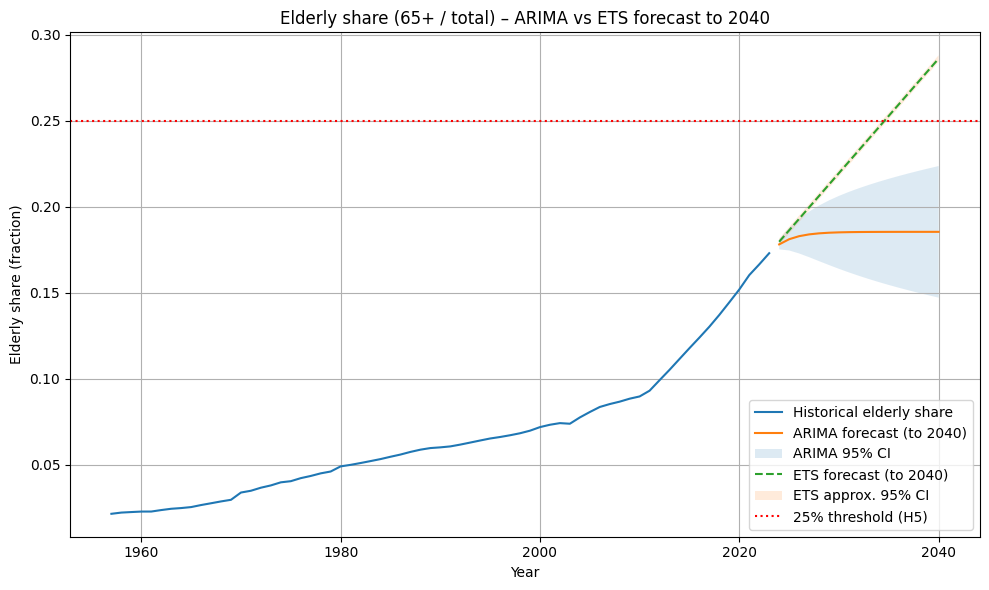

In [ ]:
# ============================================================
# Final Forecast Comparison – ARIMA vs ETS (Holt-Winters)
# Forecast horizon: up to 2040
# Prints 2035 forecasts & CIs for both models side by side
# ============================================================

# Make sure elderly_share exists from previous steps
last_year = int(elderly_share.index.max())
target_year_2035 = 2035
target_year_2040 = 2040

steps_2040 = target_year_2040 - last_year
if steps_2040 <= 0:
    raise ValueError("Data already extends to/beyond 2040 – adjust logic.")

# ------------------------------------------------------------
# 1) ARIMA(1,1,1) final forecast
# ------------------------------------------------------------
arima_final = ARIMA(elderly_share, order=(1, 1, 1)).fit()
print("\nFinal ARIMA(1,1,1) summary:")
print(arima_final.summary())

arima_forecast_res = arima_final.get_forecast(steps=steps_2040)
arima_mean = arima_forecast_res.predicted_mean
arima_ci = arima_forecast_res.conf_int(alpha=0.05)
forecast_years = np.arange(last_year + 1, target_year_2040 + 1)

# Extract ARIMA 2035 stats
if target_year_2035 in forecast_years:
    idx_2035 = list(forecast_years).index(target_year_2035)
    arima_mean_2035 = float(arima_mean.iloc[idx_2035])
    arima_lo_2035 = float(arima_ci.iloc[idx_2035, 0])
    arima_hi_2035 = float(arima_ci.iloc[idx_2035, 1])
else:
    raise ValueError("2035 not in ARIMA forecast_years – check horizon.")

# ------------------------------------------------------------
# 2) ETS (Holt-Winters, additive trend) final forecast
#     CI is approximated via residual std (normal approx)
# ------------------------------------------------------------
ets_final = ExponentialSmoothing(
    elderly_share,
    trend="add",
    seasonal=None
).fit(optimized=True)

print("\nFinal ETS (Holt-Winters, additive trend) summary:")
print(ets_final.summary())

ets_mean = ets_final.forecast(steps=steps_2040)
ets_years = np.arange(last_year + 1, target_year_2040 + 1)

# Approximate 95% CI for ETS using residual std
ets_resid = elderly_share - ets_final.fittedvalues
sigma_ets = ets_resid.std(ddof=1)
z_95 = 1.96

ets_ci_lower = ets_mean - z_95 * sigma_ets
ets_ci_upper = ets_mean + z_95 * sigma_ets

# Extract ETS 2035 stats
if target_year_2035 in ets_years:
    idx_2035_ets = list(ets_years).index(target_year_2035)
    ets_mean_2035 = float(ets_mean.iloc[idx_2035_ets])
    ets_lo_2035 = float(ets_ci_lower.iloc[idx_2035_ets])
    ets_hi_2035 = float(ets_ci_upper.iloc[idx_2035_ets])
else:
    raise ValueError("2035 not in ETS forecast_years – check horizon.")

# ------------------------------------------------------------
# 3) Print both forecasts for 2035 together
# ------------------------------------------------------------
print("\n=== 2035 Elderly Share Forecast Comparison ===")
print(
    f"ARIMA(1,1,1): mean={arima_mean_2035:.4f}, "
    f"95% CI=[{arima_lo_2035:.4f}, {arima_hi_2035:.4f}]"
)
print(
    f"ETS (Holt-Winters): mean={ets_mean_2035:.4f}, "
    f"approx. 95% CI=[{ets_lo_2035:.4f}, {ets_hi_2035:.4f}]"
)

# Optional: put into a small DataFrame for neat table view
comparison_df = pd.DataFrame(
    {
        "Model": ["ARIMA(1,1,1)", "ETS (Holt-Winters)"],
        "Mean_2035": [arima_mean_2035, ets_mean_2035],
        "CI_low_2035": [arima_lo_2035, ets_lo_2035],
        "CI_high_2035": [arima_hi_2035, ets_hi_2035],
    }
)
print("\n2035 forecast comparison table:")
print(comparison_df)

# ------------------------------------------------------------
# 4) Plot both forecasts together (to 2040)
# ------------------------------------------------------------
plt.figure()
plt.plot(
    elderly_share.index,
    elderly_share.values,
    label="Historical elderly share"
)

# ARIMA mean + CI
plt.plot(
    forecast_years,
    arima_mean.values,
    label="ARIMA forecast (to 2040)"
)
plt.fill_between(
    forecast_years,
    arima_ci.iloc[:, 0].values,
    arima_ci.iloc[:, 1].values,
    alpha=0.15,
    label="ARIMA 95% CI"
)

# ETS mean + CI
plt.plot(
    ets_years,
    ets_mean.values,
    linestyle="--",
    label="ETS forecast (to 2040)"
)
plt.fill_between(
    ets_years,
    ets_ci_lower.values,
    ets_ci_upper.values,
    alpha=0.15,
    label="ETS approx. 95% CI"
)

plt.axhline(
    0.25,
    linestyle=":",
    color="red",
    label="25% threshold (H5)"
)

plt.xlabel("Year")
plt.ylabel("Elderly share (fraction)")
plt.title("Elderly share (65+ / total) – ARIMA vs ETS forecast to 2040")
plt.legend()
plt.tight_layout()
plt.show()


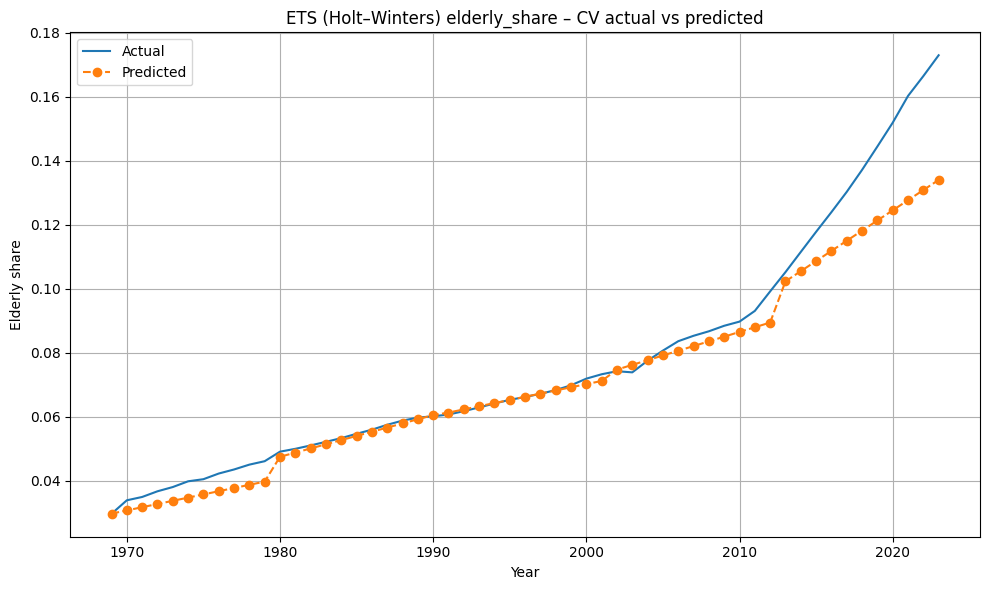

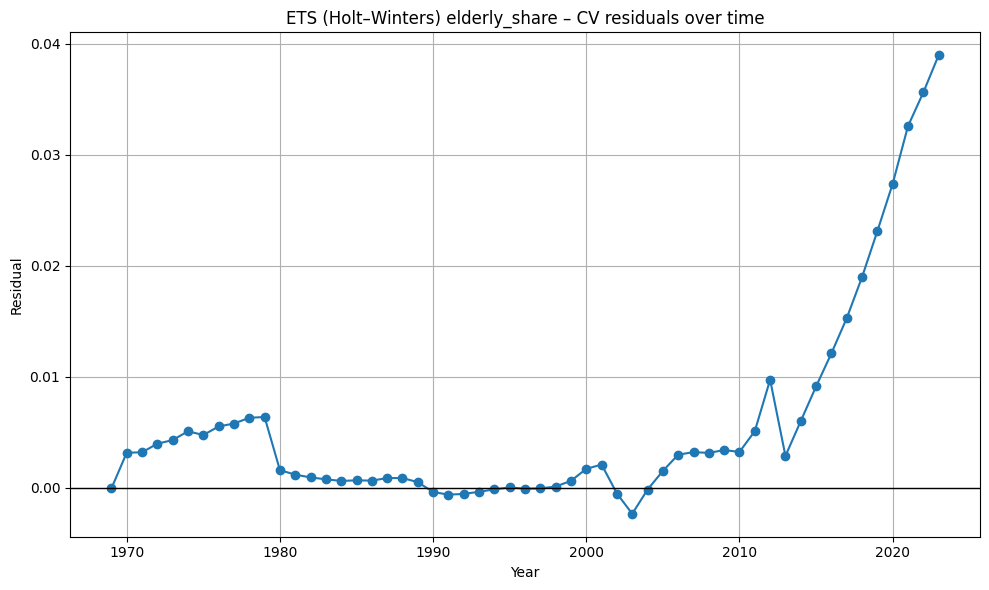

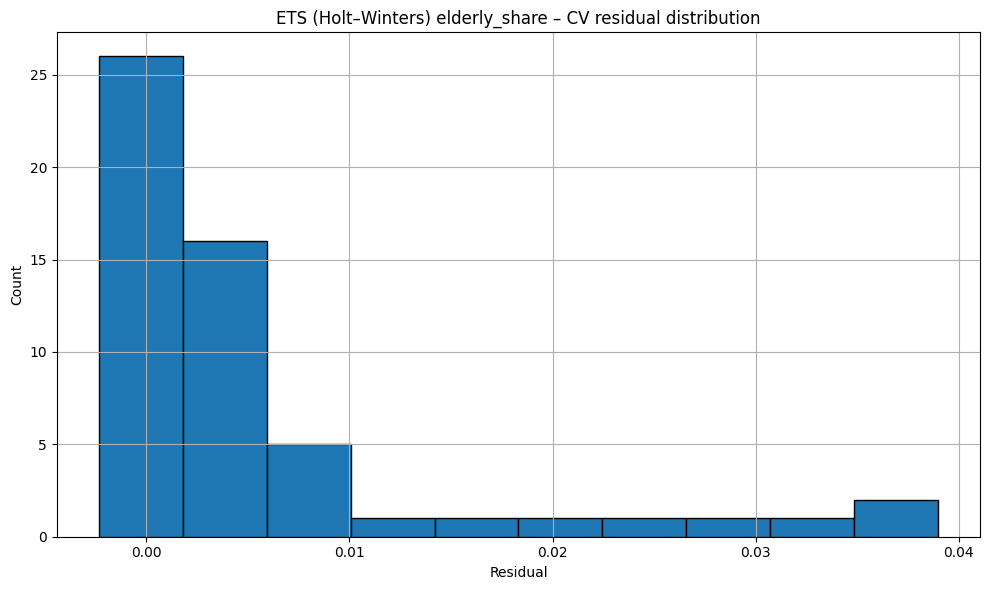

In [ ]:
# ETS CV plots (best-performing model)
plot_cv_results(ets_cv, title_prefix="ETS (Holt–Winters) elderly_share")


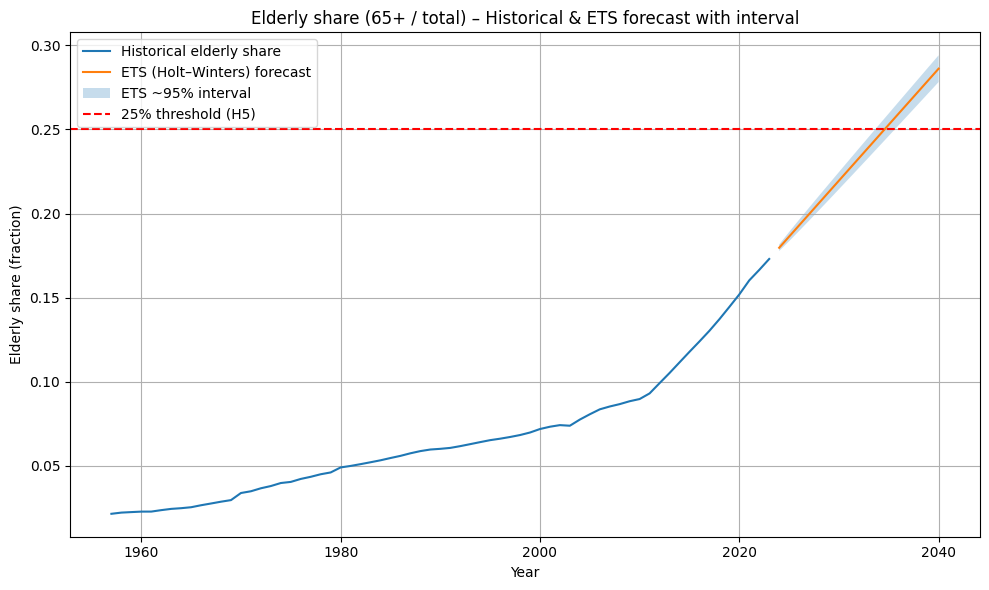

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# ETS final model + growing 95% intervals
# -------------------------------

# 1) Fit ETS (Holt–Winters) on full elderly_share
ets_final = ExponentialSmoothing(
    elderly_share,
    trend="add",
    seasonal=None
).fit(optimized=True)

# 2) Forecast to 2040
last_year = int(elderly_share.index.max())
target_year_2040 = 2040
steps_2040 = target_year_2040 - last_year

ets_forecast = ets_final.forecast(steps=steps_2040)
ets_forecast_years = np.arange(last_year + 1, target_year_2040 + 1)

# 3) Approximate forecast intervals
#    - use in-sample residual std
#    - scale by sqrt(horizon) so the band widens over time
residuals = elderly_share - ets_final.fittedvalues
sigma_resid = residuals.std(ddof=1)
z = 1.96  # ~95%

h = np.arange(1, steps_2040 + 1)                # horizons 1,2,...,H
sigma_forecast = sigma_resid * np.sqrt(h)       # widening uncertainty
ets_lower = ets_forecast - z * sigma_forecast
ets_upper = ets_forecast + z * sigma_forecast

# 4) Plot historical + ETS forecast + 95% band
plt.figure(figsize=(10, 6))

plt.plot(
    elderly_share.index,
    elderly_share.values,
    label="Historical elderly share"
)

plt.plot(
    ets_forecast_years,
    ets_forecast.values,
    label="ETS (Holt–Winters) forecast"
)

plt.fill_between(
    ets_forecast_years,
    ets_lower,
    ets_upper,
    alpha=0.25,
    label="ETS ~95% interval"
)

plt.axhline(
    0.25,
    linestyle="--",
    color="red",
    label="25% threshold (H5)"
)

plt.xlabel("Year")
plt.ylabel("Elderly share (fraction)")
plt.title("Elderly share (65+ / total) – Historical & ETS forecast with interval")
plt.legend()
plt.tight_layout()
plt.show()



ETS (Holt–Winters) model summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:            elderly_share   No. Observations:                   67
Model:             ExponentialSmoothing   SSE                              0.000
Optimized:                         True   AIC                           -919.152
Trend:                         Additive   BIC                           -910.334
Seasonal:                          None   AICC                          -917.752
Seasonal Periods:                  None   Date:                 Sun, 07 Dec 2025
Box-Cox:                          False   Time:                         04:11:13
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950033                alpha                 True

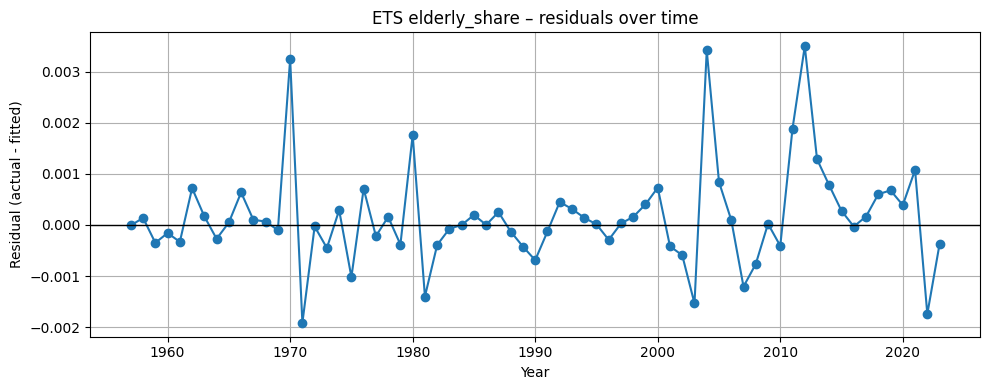

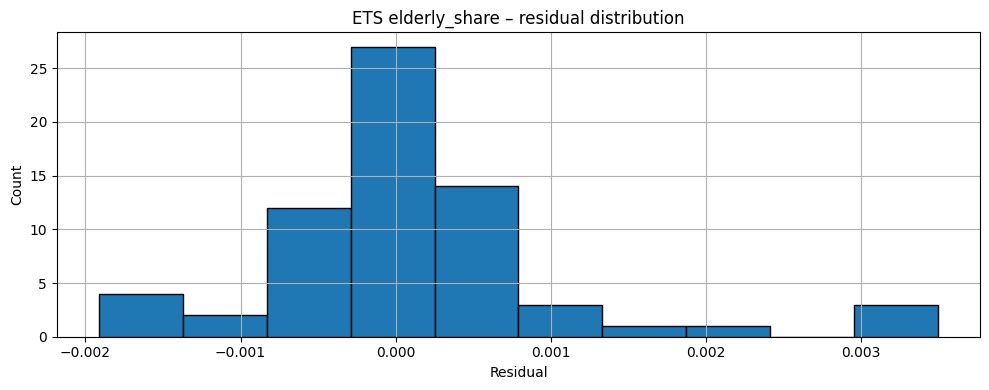


ETS residual summary:
count    67.000000
mean      0.000148
std       0.000985
min      -0.001913
25%      -0.000339
50%       0.000030
75%       0.000395
max       0.003495
dtype: float64


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# ETS (Holt–Winters) model: fit, summary, residual diagnostics
# ============================================================

# Fit ETS on full elderly_share series
ets_full = ExponentialSmoothing(
    elderly_share,
    trend="add",
    seasonal=None
).fit(optimized=True)

# 1. Text summary (similar idea to ARIMA summary but simpler)
print("\nETS (Holt–Winters) model summary:")
print(ets_full.summary())

# 2. In-sample residuals
ets_resid = elderly_share - ets_full.fittedvalues

# ---- Residuals over time ----
plt.figure(figsize=(10, 4))
plt.plot(elderly_share.index, ets_resid, marker="o")
plt.axhline(0, color="black", linewidth=1)
plt.title("ETS elderly_share – residuals over time")
plt.xlabel("Year")
plt.ylabel("Residual (actual - fitted)")
plt.tight_layout()
plt.show()

# ---- Residual histogram ----
plt.figure(figsize=(10, 4))
plt.hist(ets_resid, bins=10, edgecolor="black")
plt.title("ETS elderly_share – residual distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("\nETS residual summary:")
print(ets_resid.describe())


In [ ]:
# ------------------------------------------------------------
# 10. Overfitting check: in-sample vs cross-validated R²
# ------------------------------------------------------------
from sklearn.metrics import r2_score

# 1) Fit each model on the FULL elderly_share series (in-sample fit)
#    Use the same structure as in the CV functions.

# ETS (Holt-Winters, additive trend, no seasonality)
ets_full = ExponentialSmoothing(elderly_share, trend="add", seasonal=None)
ets_full_fit = ets_full.fit(optimized=True)
ets_fitted = ets_full_fit.fittedvalues

common_idx_ets = elderly_share.index.intersection(ets_fitted.index)
ets_r2_insample = r2_score(
    elderly_share.loc[common_idx_ets],
    ets_fitted.loc[common_idx_ets]
)

# ARIMA(1,1,1)
arima_full = ARIMA(elderly_share, order=(1, 1, 1)).fit()
arima_fitted = arima_full.fittedvalues

common_idx_arima = elderly_share.index.intersection(arima_fitted.index)
arima_r2_insample = r2_score(
    elderly_share.loc[common_idx_arima],
    arima_fitted.loc[common_idx_arima]
)

# Moving Average (5-year window) – in-sample prediction
ma_window = 5
ma_insample = elderly_share.rolling(window=ma_window).mean()
# First (window-1) years are NaN for moving average
common_idx_ma = elderly_share.index[ma_window-1:]

ma_r2_insample = r2_score(
    elderly_share.loc[common_idx_ma],
    ma_insample.loc[common_idx_ma]
)

# 2) Cross-validated R² from earlier CV runs
ets_r2_cv   = float(ets_cv["metrics"]["R2"])
arima_r2_cv = float(arima_cv["metrics"]["R2"])
ma_r2_cv    = float(ma_cv["metrics"]["R2"])

def check_overfitting(name, r2_insample, r2_cv, tol=0.15):
    gap = r2_insample - r2_cv
    print(f"\n{name}")
    print(f"  R² (in-sample fit) : {r2_insample:.3f}")
    print(f"  R² (CV)            : {r2_cv:.3f}")
    print(f"  Gap (in - CV)      : {gap:.3f}")
    if gap < tol:
        print(f"  → Gap < {tol:.2f}: No strong sign of overfitting.")
    elif gap < 0.30:
        print(f"  → Moderate gap: mild overfitting / some optimism.")
    else:
        print("  → Large gap: strong overfitting / optimistic in-sample fit.")

check_overfitting("ETS (Holt-Winters)", ets_r2_insample, ets_r2_cv)
check_overfitting("ARIMA(1,1,1)", arima_r2_insample, arima_r2_cv)
check_overfitting("Moving Average (5y)", ma_r2_insample, ma_r2_cv)



ETS (Holt-Winters)
  R² (in-sample fit) : 0.999
  R² (CV)            : 0.909
  Gap (in - CV)      : 0.090
  → Gap < 0.15: No strong sign of overfitting.

ARIMA(1,1,1)
  R² (in-sample fit) : 0.994
  R² (CV)            : 0.731
  Gap (in - CV)      : 0.263
  → Moderate gap: mild overfitting / some optimism.

Moving Average (5y)
  R² (in-sample fit) : 0.973
  R² (CV)            : 0.481
  Gap (in - CV)      : 0.493
  → Large gap: strong overfitting / optimistic in-sample fit.
